In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# Functions

In [2]:
def extract_rollouts(notebook_dir, data_folder, controller_name, additional=''):
    # print('notebook_dir', notebook_dir)
    data_folder_path = os.path.join(notebook_dir, controller_name, data_folder)
    # print('data_folder_path', data_folder_path)
    assert os.path.exists(data_folder_path), 'data_folder_path does not exist'

    # find all the subfolders in the data_folder_path
    subfolders = [f.path for f in os.scandir(data_folder_path) if f.is_dir()]
    # print('subfolders', subfolders)
    # load the row 'rmse in the metrics.txt
    metrics = []
    traj_resutls = []
    timing_data = []
    for subfolder in subfolders:
        file_path = os.path.join(subfolder, 'metrics.txt')
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if not line.startswith('rmse_std') and line.startswith('rmse'):
                    # split the text between : and \n
                    line = line.split(': ')[-1].split('\n')[0]
                    metrics.append(eval(line))

        # find the file ends with pickle and get the data
        for file in os.listdir(subfolder):
            if file.endswith('.pkl'):
                file_path = os.path.join(subfolder, file)
                # print('file_path', file_path)
                results = np.load(file_path, allow_pickle=True)
                traj_data = results['trajs_data']['obs'][0]
                timing = results['trajs_data']['controller_data'][0]['ctrl_run_time']
                traj_resutls.append(traj_data)
                timing_data.append(timing)

    traj_resutls = np.array(traj_resutls)
    traj_file_name = f'traj_results_{controller_name}{additional}.npy'
    np.save(traj_file_name, traj_resutls)
    print('traj_results.shape', traj_resutls.shape)
    # print('metrics', metrics)
    rmse_mean_mpc = np.mean(metrics)
    rmse_std_mpc = np.std(metrics)
    print(f'rmse_{controller_name}{additional}', rmse_mean_mpc, rmse_std_mpc)
    return traj_resutls, metrics, timing_data


In [3]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
def plot_xz_trajectory_with_hull(ax, traj_data, label=None, 
                                 traj_color='skyblue', hull_color='lightblue',
                                 alpha=0.5, padding_factor=1.1):
    '''Plot trajectories with convex hull showing variance over seeds.
    
    Args:
        ax (Axes): Matplotlib axes.
        traj_data (np.ndarray): Trajectory data of shape (num_seeds, num_steps, 6).
        padding_factor (float): Padding factor for the convex hull.
    '''
    num_seeds, num_steps, _ = traj_data.shape

    print('traj data shape:', traj_data.shape)
    mean_traj = np.mean(traj_data, axis=0)
    
    ax.plot(mean_traj[:, 0], mean_traj[:, 2], color=traj_color, label=label)
    # plot the hull
    for i in range(num_steps - 1):
        # plot the hull at a single step
        points_at_step = traj_data[:, i, [0, 2]]
        hull = ConvexHull(points_at_step)
        cent = np.mean(points_at_step, axis=0) # center
        pts = points_at_step[hull.vertices] # vertices
        poly = Polygon(padding_factor*(pts - cent) + cent, 
                       closed=True,  
                       capstyle='round', 
                       facecolor=hull_color,
                       alpha=alpha)
        ax.add_patch(poly)

        # connecting consecutive convex hulls
        points_at_next_step = traj_data[:, i+1, [0, 2]]
        points_connecting = np.concatenate([points_at_step, points_at_next_step], axis=0)
        hull_connecting = ConvexHull(points_connecting)
        cent_connecting = np.mean(points_connecting, axis=0)
        pts_connecting = points_connecting[hull_connecting.vertices]
        poly_connecting = Polygon(padding_factor*(pts_connecting - cent_connecting) + cent_connecting, 
                                  closed=True,  
                                  capstyle='round', 
                                  facecolor=hull_color,
                                  alpha=alpha)
        ax.add_patch(poly_connecting)

In [4]:
def run_rollouts(additional='' ):
    import mb_experiment_rollout
    start_seed = 10
    num_seed = 10
    algo = 'fmpc'
    num_runs_per_seed = 1

    for seed in range(start_seed, num_seed + start_seed):
        for _ in range(num_runs_per_seed):
            mb_experiment_rollout.run(seed=seed, Additional=additional, ALGO=algo)

In [22]:
def plot_trajectory(notebook_dir, data_folder, title):
    from safe_control_gym.utils.configuration import ConfigFactory
    from functools import partial
    from safe_control_gym.utils.registration import make
    #########################################################################
    # launch SCG to get reference trajectory X_GOAL
    ALGO = 'fmpc'
    SYS = 'quadrotor_2D_attitude'
    TASK = 'tracking'
    # PRIOR = '200_hpo'
    PRIOR = '100'
    agent = 'quadrotor' if SYS == 'quadrotor_2D' or SYS == 'quadrotor_2D_attitude' else SYS
    SAFETY_FILTER = None

    # check if the config file exists
    assert os.path.exists(f'./config_overrides/{SYS}_{TASK}.yaml'), f'../config_overrides/{SYS}_{TASK}.yaml does not exist'
    assert os.path.exists(f'./config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml'), f'../config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml does not exist'
    if SAFETY_FILTER is None:
        sys.argv[1:] = ['--algo', ALGO,
                        '--task', agent,
                        '--overrides',
                            f'./config_overrides/{SYS}_{TASK}.yaml',
                            f'./config_overrides/{ALGO}_{SYS}_{TASK}_{PRIOR}.yaml',
                        '--seed', '2',
                        '--use_gpu', 'True',
                        '--output_dir', f'./{ALGO}/results',
                            ]
    fac = ConfigFactory()
    fac.add_argument('--func', type=str, default='train', help='main function to run.')
    fac.add_argument('--n_episodes', type=int, default=1, help='number of episodes to run.')
    # merge config and create output directory
    config = fac.merge()
    # Create an environment
    env_func = partial(make,
                        config.task,
                        seed=config.seed,
                        **config.task_config
                        )
    random_env = env_func(gui=False)
    X_GOAL = random_env.X_GOAL
    ##########################################################################
    # load trajectory pkl files, load from folder
    controller_name = 'fmpc'
    fmpc_data_path = os.path.join(notebook_dir, controller_name, data_folder)
    assert os.path.exists(fmpc_data_path), 'data_folder_path does not exist'
    # fmpc_data_path = '/home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor/fmpc/results_rollout/temp'
    fmpc_data_dirs = [d for d in os.listdir(fmpc_data_path) if os.path.isdir(os.path.join(fmpc_data_path, d))]
    fmpc_traj_data_name = 'fmpc_data_quadrotor_traj_tracking.pkl'
    fmpc_traj_data_name = [os.path.join(d, fmpc_traj_data_name) for d in fmpc_data_dirs]

    fmpc_data = []
    for d in fmpc_traj_data_name:
        fmpc_data.append(np.load(os.path.join(fmpc_data_path, d), allow_pickle=True))
    fmpc_traj_data = [d['trajs_data']['obs'][0] for d in fmpc_data]
    fmpc_traj_data = np.array(fmpc_traj_data)
    print(fmpc_traj_data.shape) # seed, time_step, obs
    # take average of all seeds
    mpc_mean_traj_data = np.mean(fmpc_traj_data, axis=0)
    print(mpc_mean_traj_data.shape) # (mean_541, 6)


    # Define Colors
    ref_color = 'black'
    fmpc_color = 'purple'
    fmpc_hull_color = 'violet'

    # plot the state path x, z [0, 2]
    title_fontsize = 20
    legend_fontsize = 14
    axis_label_fontsize = 14
    axis_tick_fontsize = 12

    fig, ax = plt.subplots(figsize=(8, 4))
    # adjust the distance between title and the plot
    fig.subplots_adjust(top=0.2)
    ax.plot(X_GOAL[:, 0], X_GOAL[:, 2], color=ref_color, linestyle='-.', label='Reference')
    # ax.plot()
    ax.set_xlabel('$x$ [m]', fontsize=axis_label_fontsize)
    ax.set_ylabel('$z$ [m]', fontsize=axis_label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=axis_tick_fontsize)
    # ax.set_title('State path in $x$-$z$ plane')
    # set the super title
    # if not generalization:
    #     fig.suptitle(f'Evaluation ({plot_name})', fontsize=title_fontsize)
    # else:
    #     fig.suptitle(f'Generalization ({plot_name})', fontsize=title_fontsize)
    fig.suptitle(title, fontsize=title_fontsize)
    ax.set_ylim(0.35, 1.85)
    ax.set_xlim(-1.6, 1.6)
    fig.tight_layout()


    # plot the convex hull of each steps
    k = 1.1 # padding factor
    alpha = 0.2

    plot_xz_trajectory_with_hull(ax, fmpc_traj_data, label='FMPC',
                                    traj_color=fmpc_color, hull_color=fmpc_hull_color,
                                    alpha=alpha, padding_factor=k)

    ax.legend(ncol=5, loc='upper center', fontsize=legend_fontsize)

    fig.savefig(os.path.join(fmpc_data_path, 'xz_path_performance.png'), dpi=300, bbox_inches='tight')

# Run FMPC Rollouts

In [5]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print('notebook_dir', notebook_dir)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
s = 2 # times of std

notebook_dir /home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor


In [6]:
# additionals_list = ['']
additionals_list = ['', '_slow', '_fast']

In [ ]:
for additional in additionals_list:
    run_rollouts(additional)

### get mean rmse 

In [7]:
ctrl = 'fmpc'
# for additional in additionals_list:
#     data_folder = f'results_rollout{additional}/temp'
#     traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additional)

additional = ''
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, timing_data = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_perf = np.mean(metrics) # spider plot performance

additional = '_slow'
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, _ = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_gen_slow = np.mean(metrics) # spider plot generalization performance slow

additional = '_fast'
data_folder = f'results_rollout{additional}/temp'
traj_resutls, metrics, _ = extract_rollouts(notebook_dir, data_folder, ctrl, additional)
sp_plot_gen_fast = np.mean(metrics) # spider plot generalization performance fast

print('rmse_eval:', sp_plot_perf)
print('rmse_slow:', sp_plot_gen_slow)
print('rmse_fast:', sp_plot_gen_fast)

traj_results.shape (10, 661, 6)
rmse_fmpc 0.059137026736069555 0.005832082354708504
traj_results.shape (10, 901, 6)
rmse_fmpc_slow 0.03564133969521756 0.004469864438348685
traj_results.shape (10, 541, 6)
rmse_fmpc_fast 0.08429032777660553 0.007318884964910064
rmse_eval: 0.059137026736069555
rmse_slow: 0.03564133969521756
rmse_fast: 0.08429032777660553


### Evaluate mean execution time --> Inference time in spider plot

In [8]:
time_vector = (np.squeeze(timing_data)).flatten()
mean_exec_time = np.mean(time_vector)
max_exec_time = np.max(time_vector)
print('Mean execution time:', mean_exec_time)
print('Max execution time:', max_exec_time)
sp_plot_inf_time = mean_exec_time # save for later, spider plot

Mean execution time: 0.005382973714308305
Max execution time: 0.07280445098876953


# Plot Trajectory with Hull - like slide 8

Later this needs to be added to the other Model based algorithms, cannot do that right now as I don't have that data

/home/tobias/miniconda3/envs/safe/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(10, 661, 6)
(661, 6)
traj data shape: (10, 661, 6)
(10, 901, 6)
(901, 6)
traj data shape: (10, 901, 6)
(10, 541, 6)
(541, 6)
traj data shape: (10, 541, 6)


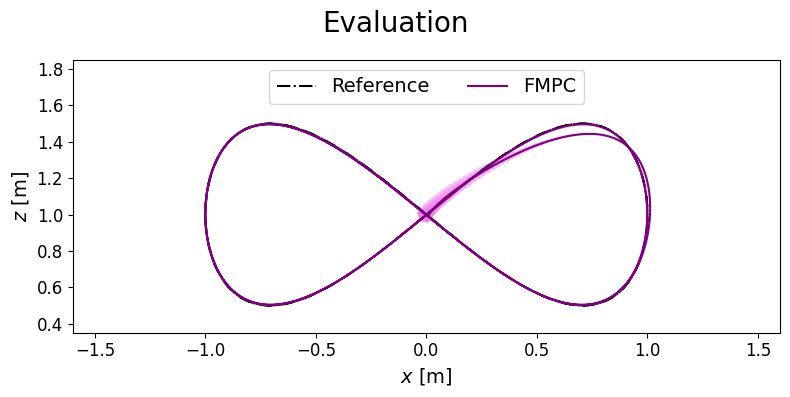

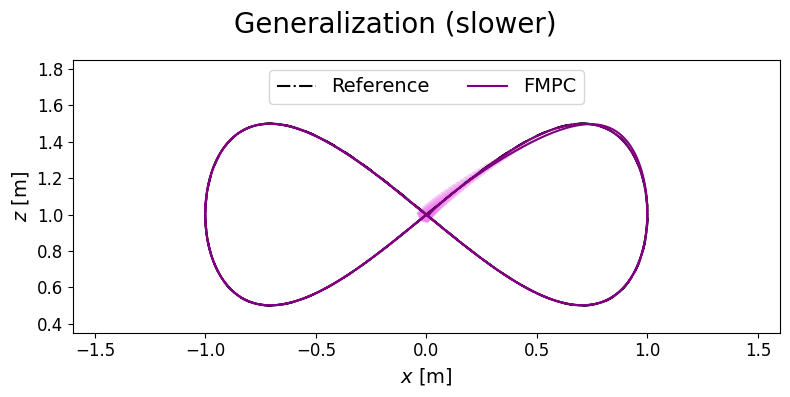

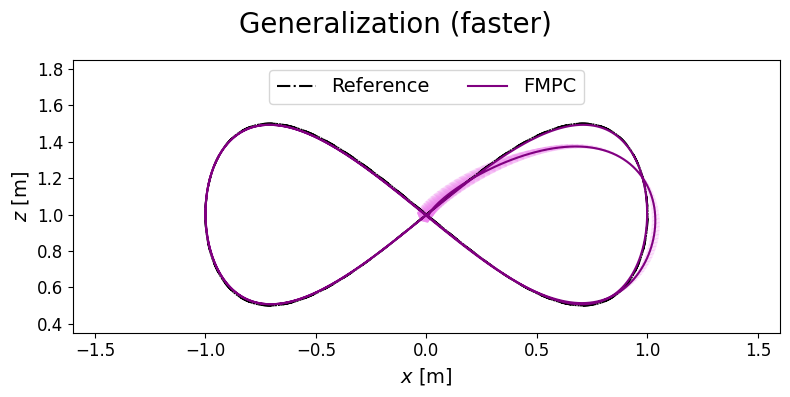

In [23]:
additional = ''
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Evaluation')

additional = '_slow'
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Generalization (slower)')

additional = '_fast'
data_folder = f'results_rollout{additional}/temp'
plot_trajectory(notebook_dir, data_folder, 'Generalization (faster)')

# Robustness

### run robustness experiments

In [10]:
import mb_experiment_noise
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
noise_factors = np.arange(0, 210, 10)
# noise_factors = [1, 10, 20, 30, 40]



In [ ]:
for seed in seeds:
    for noise_fac in noise_factors:
        mb_experiment_noise.run(seed=seed, noise_factor=noise_fac)

### Evaluate Robustness, adapted from plot_noise.ipynb

In [11]:
# robustness evaluation
import pandas as pd
import matplotlib.pyplot as plt

controller = 'fmpc'
prior = 'results_noise'

max_seed = 2
max_seed = len(seeds)
metric_name = 'metrics.txt'
s = 2 # times std
obs_dim = 6

# get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_color = {'ilqr': 'gray', 'gpmpc_acados': colors[0], 'mpc_acados':colors[-1], 'linear_mpc':colors[2], 'fmpc': colors[4]} 

In [12]:

data_folder_dir = f'./{controller}/{prior}/'
# find the folder in the dir
seed_data_folder = os.listdir(os.path.join(notebook_dir, data_folder_dir))
print('seed_data_folder', seed_data_folder)
seed_data_folder = [f for f in seed_data_folder if os.path.isdir(os.path.join(data_folder_dir, f))]
seed_data_folder = sorted(seed_data_folder, key=lambda x: int(x.split('_')[1]))

seed_data_folder = [os.path.join(data_folder_dir, f, 'temp') for f in seed_data_folder]
print('seed_data_folder', seed_data_folder)

seed_data_folder ['seed_4', 'seed_10', 'seed_6', 'noise_plot2.png', 'seed_3', 'seed_9', 'seed_1', 'noise_plot.png', 'seed_5', 'seed_7', 'seed_2', 'seed_8']
seed_data_folder ['./fmpc/results_noise/seed_1/temp', './fmpc/results_noise/seed_2/temp', './fmpc/results_noise/seed_3/temp', './fmpc/results_noise/seed_4/temp', './fmpc/results_noise/seed_5/temp', './fmpc/results_noise/seed_6/temp', './fmpc/results_noise/seed_7/temp', './fmpc/results_noise/seed_8/temp', './fmpc/results_noise/seed_9/temp', './fmpc/results_noise/seed_10/temp']


In [13]:
results = {}

for seed in range(0, max_seed):
    results[repr(seed)] = {}
    rmse_list = []
    early_stop_list = []
    noise_factor_list = []
    traj_data_list = []
    traj_steps_list = []
    # fild runs
    load_seed_dir = seed_data_folder[seed]
    runs_data_folder = os.listdir(os.path.join(notebook_dir, load_seed_dir))
    runs_data_folder = [os.path.join(load_seed_dir, f) for f in runs_data_folder]
    # sort the runs
    runs_data_folder = sorted(runs_data_folder)
    print('runs_data_folder', runs_data_folder)
    for runs in runs_data_folder:
        # load the metric file in the folder
        metric_file = os.path.join(runs, metric_name)
        # print('metric_file', metric_file)
        data = pd.read_csv(metric_file, delimiter=':')
        # convert to numpy
        data = data.to_numpy()
        # print(data)
        # convert to dictionary
        data = {data[i][0]: data[i][1] for i in range(len(data))}

        noise_factor = eval(data['noise_factor'])
        rmse = eval(data['rmse'])
        early_stop = eval(data['early_stop'])
        rmse_list.append(rmse)
        early_stop_list.append(early_stop)
        noise_factor_list.append(noise_factor)

        # load the traj
        traj_file = os.path.join(runs, f'{controller}_data_quadrotor_traj_tracking.pkl')
        traj_data = pd.read_pickle(traj_file)
        traj_data = traj_data['trajs_data']['obs'][0]
        traj_steps = len(traj_data)
        traj_data_list.append(traj_data)
        traj_steps = len(traj_data)
        traj_steps_list.append(traj_steps)
    
    results[repr(seed)]['rmse'] = rmse_list
    results[repr(seed)]['early_stop'] = early_stop_list
    results[repr(seed)]['noise_factor'] = noise_factor_list
    # results[repr(seed)]['traj_data'] = traj_data_list
    results[repr(seed)]['traj_steps'] = traj_steps_list

max_noise_factor = max([max(results[repr(seed)]['noise_factor']) for seed in range(max_seed)])

runs_data_folder ['./fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-11_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-15_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-19_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-23_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-30_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-35_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-39_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-46_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-51_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-52-57_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-53-03_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-53-10_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-53-16_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-53-21_d2fa9a6', './fmpc/results_noise/seed_1/temp/seed1_Nov-22-10-53-27_d2

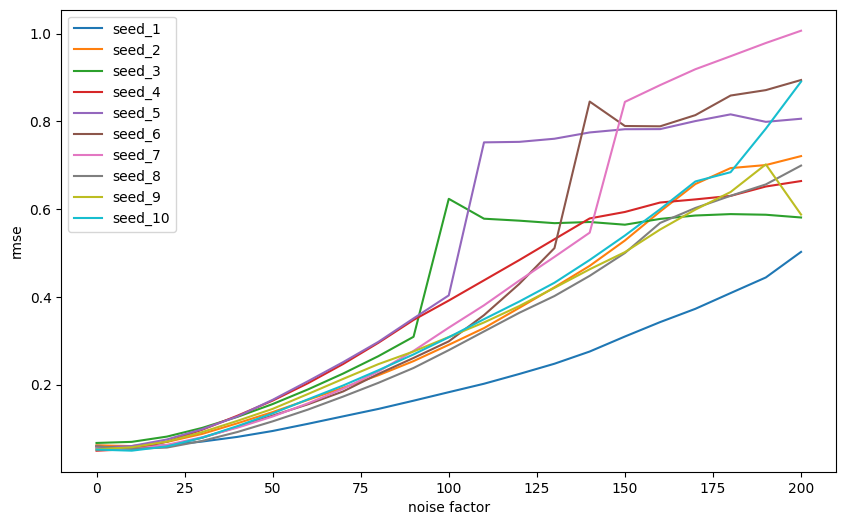

In [14]:
# plot the results
# x axis noise factor
# y axis rmse
fig, ax = plt.subplots(figsize=(10, 6))
for seed in range(max_seed):
    ax.plot(results[repr(seed)]['noise_factor'], results[repr(seed)]['rmse'], label=f'seed_{seed+1}')
ax.set_xlabel('noise factor')
ax.set_ylabel('rmse')
ax.legend()
fig.savefig(os.path.join(notebook_dir, 'fmpc/results_noise/noise_plot.png'), bbox_inches='tight')



In [15]:
results_file_name = f'{notebook_dir}/data/noise_results_{controller}.npy'
np.save(results_file_name, results)
print(f'saved {notebook_dir}/{results_file_name}')


saved /home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor//home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor/data/noise_results_fmpc.npy


### Evaluate early stop

In [16]:
# early stop
num_noise_factor = len(results[repr(seed)]['noise_factor'])
print('num_noise_factor', num_noise_factor)
early_stop_results = [False for _ in range(num_noise_factor)]
# print('early_stop_results', early_stop_results)
# print('len(early_stop_results)', len(early_stop_results))
for seed in range(max_seed):
    for i in range(len(results[repr(seed)]['noise_factor'])):
        early_stop_results[i] = early_stop_results[i] or results[repr(seed)]['early_stop'][i]
print('early_stop_results', early_stop_results)
# find the first early stop
if True in early_stop_results:
    first_early_stop = early_stop_results.index(True)
    early_stop_noise_factor = results[repr(seed)]['noise_factor'][first_early_stop]
    sp_plot_robustness = early_stop_noise_factor # later for spider plot
else:
    print('no early stop')
    first_early_stop = None
    early_stop_noise_factor = None
    sp_plot_robustness = np.max(noise_factors) # later for spider plot
print('first_early_stop', first_early_stop)
print('early_stop_noise_factor', early_stop_noise_factor)

num_noise_factor 21
early_stop_results [False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True]
first_early_stop 10
early_stop_noise_factor 100


In [17]:
# overwrite early stop if it does not stop early
early_stop_noise_factor = sp_plot_robustness

0.05712911913015385

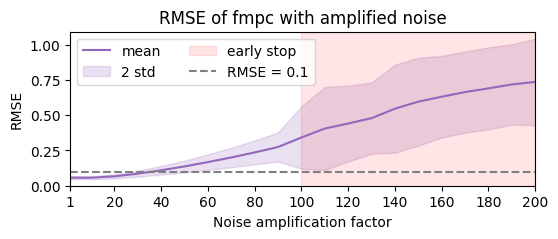

In [21]:
mean_rmse = np.mean([results[repr(seed)]['rmse'] for seed in range(max_seed)], axis=0)
std_rmse = np.std([results[repr(seed)]['rmse'] for seed in range(max_seed)], axis=0)

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(results[repr(seed)]['noise_factor'], mean_rmse, 
        label='mean', color=plot_color[controller])
ax.fill_between(results[repr(seed)]['noise_factor'], mean_rmse- s*std_rmse, mean_rmse+ s*std_rmse, 
                alpha=0.2, label=f'{s} std', color=plot_color[controller])

# plot shaded area for the first early stop
ax.axvspan(early_stop_noise_factor, max_noise_factor, color='red', alpha=0.1, label='early stop')

ax.set_xlim([1, max_noise_factor])
ax.set_ylim([0, None])
# explicitly show the tick from 1 to the max noise factor
noise_ticks = [i for i in range(20, max_noise_factor+1, 20)]
# append 1 at the beginning
noise_ticks = [1] + noise_ticks
ax.set_xticks(noise_ticks)
# plot y line at 0.1
ax.axhline(y=0.1, color='gray', linestyle='--', label='RMSE = 0.1')
ax.legend(ncol=2)
ax.set_xlabel('Noise amplification factor')
ax.set_ylabel('RMSE')
ax.set_title(f'RMSE of {controller} with amplified noise')
fig.savefig(os.path.join(notebook_dir, 'fmpc/results_noise/noise_plot2.png'), dpi=300, bbox_inches='tight')
mean_rmse[0]

# Generate Spider Plot

In [27]:
# check that all previously computed variables are computed
sp_plot_perf
sp_plot_gen_slow
sp_plot_gen_fast
sp_plot_robustness

# temporary
# sp_plot_inf_time = 0.004

# manually set parameter
sp_plot_model_knowledge = 3
sp_plot_sampling_complex = 1

print('performance', sp_plot_perf)
print('generalization_slow', sp_plot_gen_slow)
print('generalization_fast', sp_plot_gen_fast)
print('robustness', sp_plot_robustness)
print('sampling complex', sp_plot_sampling_complex)
print('model knowledge', sp_plot_model_knowledge)

performance 0.059137026736069555
generalization_slow 0.03564133969521756
generalization_fast 0.08429032777660553
robustness 100
sampling complex 1
model knowledge 3


['FMPC', 'FMPC', 'MAX', 'MIN']
tiks: ['$\\qquad\\qquad\\qquad\\quad$  Generalization\n $\\qquad\\qquad\\qquad\\quad$ performance\n\n', '$\\qquad\\qquad\\qquad\\quad$ Performance\n', 'Inference\ntime\n\n', 'Model                \nknowledge                ', '\n\n\nSampling\ncomplexity', '\n\nRobustness', '$\\qquad\\qquad\\qquad\\quad$  Generalization\n $\\qquad\\qquad\\qquad\\quad$ performance\n\n']


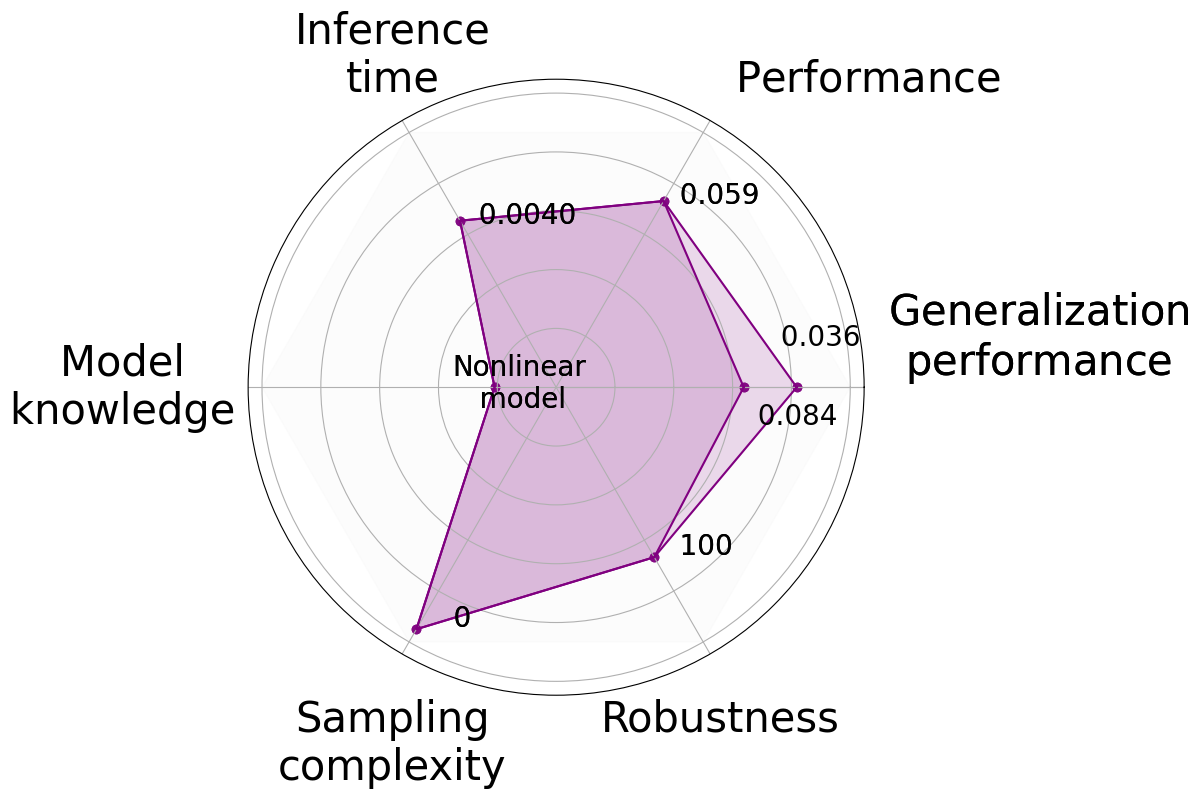

figure saved as /home/tobias/Studium/masterarbeit/code/safe-control-gym/benchmarking_sim/quadrotor/plotting/FMPC_radar.png


In [26]:
from benchmarking_sim.quadrotor.plotting.plot_radar import spider

num_axis = 6
gen_performance = [0.07240253210609013, 0.031425261835490235,  # GP-MPC
                0.10363015782869267, 0.03574250675445726,  # Linear-MPC
                0.06669989755434953, 0.023313325828377546,  # MPC
                0.049631400535807925, 0.047894774207991445,  # PPO
                0.12754716185055215, 0.08743083392874743,  # SAC
                0.050426782816096215, 0.04861203156962396,  # DPPO
                sp_plot_gen_slow, sp_plot_gen_fast,  # FMPC

                ]
performance = [0.049872511450839645, 0.049872511450839645,  # GP-MPC
            0.06556989411791102, 0.06556989411791102,  # Linear-MPC
            0.04421752503119518, 0.04421752503119518,  # MPC
            0.01746153113470009, 0.01746153113470009,  # PPO
            0.0764178745409007, 0.0764178745409007,  # SAC
            0.01931011838369746, 0.01931011838369746,  # DPPO
            sp_plot_perf, sp_plot_perf,  # FMPC
            ]
inference_time = [0.0090775150246974736, 0.0090775150246974736,
                0.0011251235, 0.0011251235,
                0.0061547613, 0.0061547613,
                0.00020738168999000832, 0.00020738168999000832,
                0.00024354409288477016, 0.00024354409288477016,
                0.0001976909460844817, 0.0001976909460844817,
                sp_plot_inf_time, sp_plot_inf_time,  # FMPC
                ]
model_complexity = [80, 80,
                    40, 40,
                    80, 80,
                    1, 1,
                    1, 1,
                    1, 1,
                    80, 80]
sampling_complexity = [int(660), int(660),
                    int(1), int(1),
                    int(1), int(1),
                    int(2.8 * 1e5), int(2.8 * 1e5),
                    int(2 * 1e5), int(2 * 1e5),
                    int(2.5 * 1e5), int(2.5 * 1e5),
                    int(1), int(1)]
robustness = [120, 120,
            90, 90,
            90, 90,
            10, 10,
            30, 30,
            20, 20, 
            sp_plot_robustness, sp_plot_robustness]
data = [gen_performance, performance, inference_time, model_complexity, sampling_complexity, robustness]
max_values = [0.01, 0.01, 1e-5, 1, 1, 120]
min_values = [0.2, 0.2, 1e-2, 80, 3.e5, 1]

for i, d in enumerate(data):
    data[i].append(max_values[i])
    data[i].append(min_values[i])

# append the max and min values to the data
algos = ['GP-MPC', 'GP-MPC',
        'Linear MPC', 'Linear MPC',
        'Nonlinear MPC', 'Nonlinear MPC',
        'PPO', 'PPO',
        'SAC', 'SAC',
        'DPPO', 'DPPO',
        'FMPC', 'FMPC',
        'MAX', 'MIN']
    # apppend the max and min values to the data


masks_algo = [12, 13, -2, -1] #FMPC
#masks_algo = [0, 1, -2, -1] #GPMPC
data = np.array(data)[:, masks_algo]
data = data.tolist()
algos = [algos[i] for i in masks_algo]
print(algos)

spider(
    pd.DataFrame({
        # 'x': [*'ab'],
        'x': algos,
        '$\qquad\qquad\qquad\quad$  Generalization\n $\qquad\qquad\qquad\quad$ performance\n\n':
            data[0],
        '$\qquad\qquad\qquad\quad$ Performance\n':
            data[1],
        # '$\quad\quad\quad\quad\quad\qquad$(Figure-8 tracking)': [3.94646538e-02, 0.03],
        'Inference\ntime\n\n':
            data[2],
        'Model                \nknowledge                ':
            [int(data[3][i]) for i in range(len(data[3]))],
        '\n\n\nSampling\ncomplexity':
            data[4],
        '\n\nRobustness':
            [int(data[5][i]) for i in range(len(data[5]))],
    }),

    id_column='x',
    # title='   Overall Comparison',
    # title = algos[0],
    title=None,
    # subtitle='(Normalized linear scale)',
    padding=1.1,
    # padding=1,
    plt_name=algos[0],
)
